# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [115]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [122]:
X_train, y_train = train["X"], train["y"]
X_test, y_test = test["X"], test["y"]

# Format data to make it easier to handle
X_train = np.moveaxis(X_train, [3], [0])
X_test = np.moveaxis(X_test, [3], [0])

y_train -= 1
y_test -= 1

In [127]:
def get_label(raw):
    return raw + 1 if raw < 9 else 0

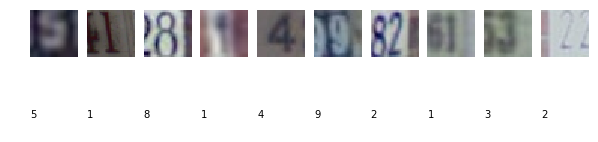

In [129]:
indexes = np.random.randint(low=0, high=len(X_train) - 1, size=10)
fig, ax = plt.subplots(2, 10, figsize=(10, 2))

j = 0
for i in indexes:
    
    ax[0][j].set_axis_off()
    ax[0][j].imshow(X_train[i])
    
    ax[1][j].set_axis_off()
    ax[1][j].text(0,0,str(get_label(y_train[i,0])))
    
    j += 1

In [131]:
X_train = np.average(X_train, axis=3)
X_test = np.average(X_test, axis=3)

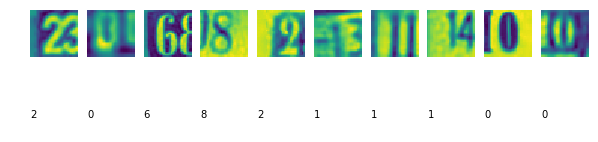

In [133]:
indexes = np.random.randint(low=0, high=len(X_train) - 1, size=10)
fig, ax = plt.subplots(2, 10, figsize=(10, 2))

j = 0
for i in indexes:
    
    ax[0][j].set_axis_off()
    ax[0][j].imshow(X_train[i])
    
    ax[1][j].set_axis_off()
    ax[1][j].text(0,0,str(get_label(y_train[i,0])))
    
    j += 1

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [55]:
filepath = "checkpoints_epoch_saves1/checkpoint_{epoch:02d}"
checkpoint_epochs = ModelCheckpoint(
    filepath=filepath,
    frequency="epoch",
    verbose=1,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor="loss",
    patience=5,
    mode="min",
    verbose=True
)

In [78]:
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape=(32,32,1), name="flatten"),
        Dense(128, activation="relu", kernel_initializer=glorot_normal(), name="dense_1"),
        Dense(64, activation="relu", kernel_initializer=glorot_normal(), name="dense_2"),
        Dense(64, activation="relu", kernel_initializer=glorot_normal(), name="dense_3"),
        Dense(10, activation="softmax", kernel_initializer=glorot_normal(), name="dense_4"),
    ])
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["acc"]
    )
    
    return model

model = get_mlp_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
)

In [58]:
# Use 10% of training set as validation

history = model.fit(
    X_train[...,np.newaxis], y_train,
    validation_split=0.1,
    epochs=20,
    callbacks=[checkpoint_epochs, early_stopping],
    verbose=True
)

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
65856/65931 [============================>.] - ETA: 0s - loss: 3.5671 - acc: 0.1614- ETA: 0s - loss: 3.5734 - acc: 0.16
Epoch 00001: saving model to checkpoints_epoch_saves1/checkpoint_01
65931/65931 [==============================] - 49s 745us/sample - loss: 3.5654 - acc: 0.1615 - val_loss: 2.1637 - val_acc: 0.2551
Epoch 2/20
65920/65931 [============================>.] - ETA: 0s - loss: 2.0317 - acc: 0.2868
Epoch 00002: saving model to checkpoints_epoch_saves1/checkpoint_02
65931/65931 [==============================] - 48s 722us/sample - loss: 2.0317 - acc: 0.2869 - val_loss: 1.8997 - val_acc: 0.3460
Epoch 3/20
65888/65931 [============================>.] - ETA: 0s - loss: 1.6858 - acc: 0.4274
Epoch 00003: saving model to checkpoints_epoch_saves1/checkpoint_03
65931/65931 [==============================] - 47s 716us/sample - loss: 1.6859 - acc: 0.4274 - val_loss: 2.1186 - val_acc: 0.3155
Epoch 4/20
65888/65931 [============

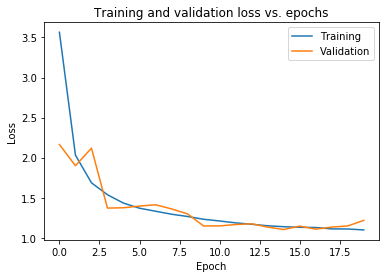

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show() 

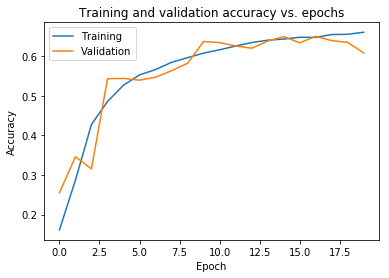

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show() 

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [61]:
filepath_cnn = "checkpoints_epoch_saves_cnn_1/checkpoint_{epoch:02d}"
checkpoint_epochs = ModelCheckpoint(
    filepath=filepath_cnn,
    frequency="epoch",
    verbose=1,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor="val_acc",
    patience=3,
    mode="max",
    verbose=True
)

In [77]:
def get_cnn_model():
    model = Sequential([
        Conv2D(
            16, kernel_size=(3,3), 
            kernel_initializer=glorot_normal(), activation="relu", 
            padding="SAME", name="conv_1", input_shape=(32,32,1)
        ),
        MaxPooling2D((2,2), name="pool_1"),
        Conv2D(
            8, kernel_size=(3,3), 
            kernel_initializer=glorot_normal(), activation="relu", 
            padding="SAME", name="conv_2"
        ),
        MaxPooling2D((2,2), name="pool_2"),
        Flatten(name="flatten"),
        Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_1"),
        Dropout(0.3, name="dropout_1"),
        BatchNormalization(name="norm_1"),
        Dense(64, activation="relu", kernel_regularizer=l2(0.01), name="dense_2"),
        Dropout(0.3, name="dropout_2"),
        BatchNormalization(name="norm_2"),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01), name="dense_3"),
        Dropout(0.3, name="dropout_3"),
        BatchNormalization(name="norm_3"),
        Dense(10, activation="softmax", name="dense_4")
    ])

    model_cnn.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["acc"]
    )
    
    return model

model_cnn = get_cnn_model()
model_cnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 8)         1160      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)             

In [64]:
# Use 10% of training set as validation

history_cnn = model_cnn.fit(
    X_train[..., np.newaxis], y_train,
    validation_split=0.1,
    epochs=20,
    callbacks=[checkpoint_epochs, early_stopping],
    verbose=True
)

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
65920/65931 [============================>.] - ETA: 0s - loss: 2.9053 - acc: 0.1639
Epoch 00001: saving model to checkpoints_epoch_saves_cnn_1/checkpoint_01
65931/65931 [==============================] - 246s 4ms/sample - loss: 2.9052 - acc: 0.1639 - val_loss: 2.3451 - val_acc: 0.1885
Epoch 2/20
65920/65931 [============================>.] - ETA: 0s - loss: 2.2577 - acc: 0.2087
Epoch 00002: saving model to checkpoints_epoch_saves_cnn_1/checkpoint_02
65931/65931 [==============================] - 242s 4ms/sample - loss: 2.2577 - acc: 0.2087 - val_loss: 1.9967 - val_acc: 0.3058
Epoch 3/20
65920/65931 [============================>.] - ETA: 0s - loss: 1.7407 - acc: 0.4305
Epoch 00003: saving model to checkpoints_epoch_saves_cnn_1/checkpoint_03
65931/65931 [==============================] - 239s 4ms/sample - loss: 1.7407 - acc: 0.4305 - val_loss: 1.3010 - val_acc: 0.6122
Epoch 4/20
65920/65931 [============================>.] - ET

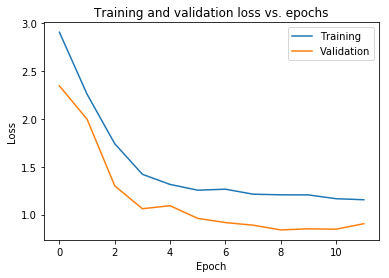

In [67]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Training and validation loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show() 

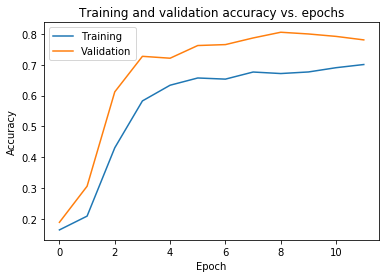

In [68]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Training and validation accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show() 

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [93]:
model_mlp = get_mlp_model()
model_mlp.load_weights(
    tf.train.latest_checkpoint(
        "checkpoints_epoch_saves1", latest_filename=None
    )
)

model_cnn = get_cnn_model()
model_cnn.load_weights(
    tf.train.latest_checkpoint(
        "checkpoints_epoch_saves_cnn_1", latest_filename=None
    )
)

In [146]:
def plot_data(model, test_data):
    
    # Plot Results
    indexes = np.random.randint(low=0, high=len(test_data) - 1, size=5)
    fig, ax = plt.subplots(5, 3, figsize=(20,20))

    j = 0
    for i in indexes:
        prediction_data = model.predict(test_data[i][np.newaxis, ..., np.newaxis])
        prediction_data = prediction_data.T

        # Print image
        ax[j][0].set_axis_off()
        ax[j][0].imshow(test_data[i])

        # Print classes distribution
        ax[j][1].bar(
            [str(x+1) for x in range(9)] + ["0"],
            prediction_data[:,0]
        )

        # Print highest score item
        predicted = np.argmax(prediction_data)
        ax[j][2].set_axis_off()
        ax[j][2].text(0,0,"Chosen class is " + str(get_label(predicted)))

        j += 1

    plt.show()

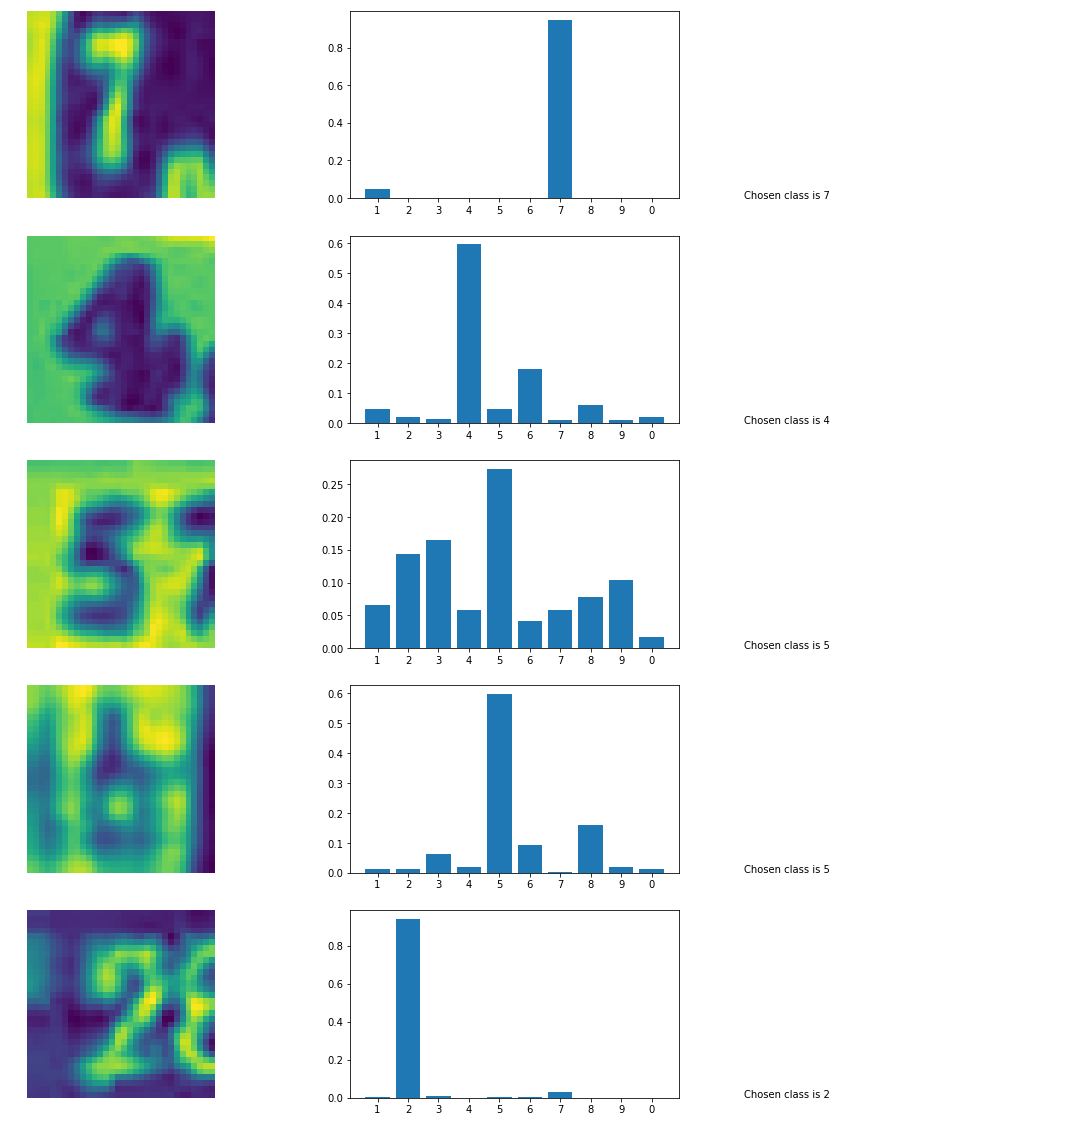

In [147]:
plot_data(model_mlp, X_test)

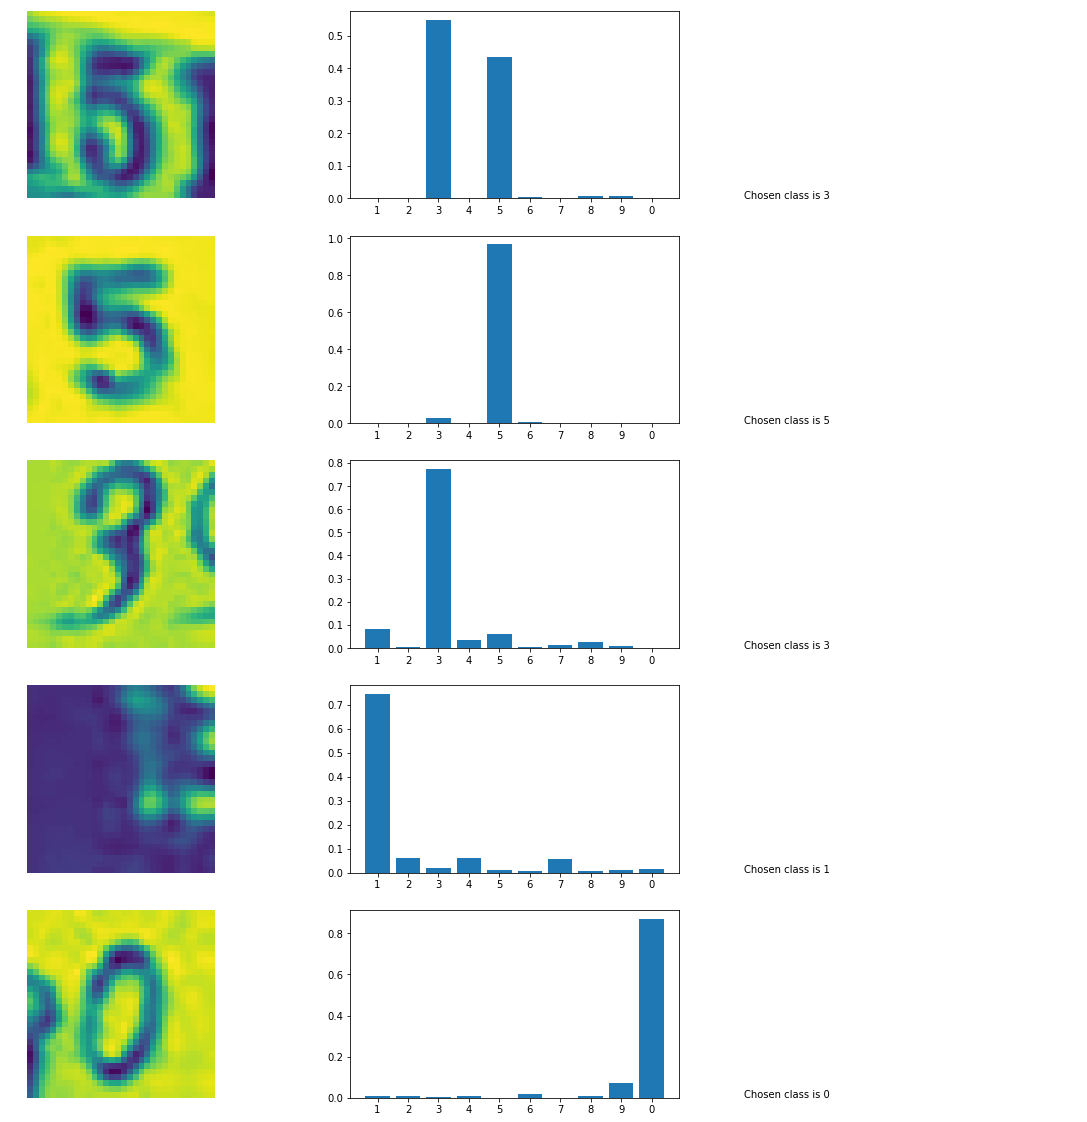

In [149]:
plot_data(model_cnn, X_test)